# Open-ST Mouse Head

This notebook processes the Open-ST mouse brain / mouse head dataset using two replicates:

- `/Users/chrislangseth/Downloads/GSM7990097_e13_mouse_head.h5ad`
- `/Users/chrislangseth/Downloads/GSM8193337_e13_mouse_head_rep.h5ad`

Related KaroSpace viewer export:

- `/Users/chrislangseth/Downloads/KaroSpace_20260227_121016.html`

The embedded KaroSpace payload matches this combined dataset and contains two sections, `mouse_head` and `mouse_head_rep`, for a total of `84220` cells.

Citation:

Schott, M. et al. Open-ST: High-resolution spatial transcriptomics in 3D. *Cell* 187, 3953-3972.e26 (2024).

In [38]:
import anndata as ad
import h5py
import scanpy as sc
from anndata.io import read_elem

In [39]:
H5AD_PATHS = {
    "mouse_head": "/Users/chrislangseth/Downloads/GSM7990097_e13_mouse_head.h5ad",
    "mouse_head_rep": "/Users/chrislangseth/Downloads/GSM8193337_e13_mouse_head_rep.h5ad",
}

def read_h5ad_robust(path):
    try:
        return ad.read_h5ad(path)
    except Exception:
        with h5py.File(path, "r") as f:
            kwargs = {}
            for key in ["X", "obs", "var", "uns", "obsm", "varm", "obsp", "varp"]:
                if key in f:
                    kwargs[key] = read_elem(f[key])

            if "layers" in f:
                layers = {}
                for name in f["layers"].keys():
                    obj = f["layers"][name]
                    if (
                        name == "raw"
                        and isinstance(obj, h5py.Group)
                        and obj.attrs.get("encoding-type") == "anndata"
                    ):
                        continue
                    layers[name] = read_elem(obj)
                kwargs["layers"] = layers

            adata = ad.AnnData(**kwargs)

            if "layers" in f and "raw" in f["layers"]:
                raw_group = f["layers"]["raw"]
                if isinstance(raw_group, h5py.Group) and raw_group.attrs.get("encoding-type") == "anndata":
                    raw_varm = read_elem(raw_group["varm"]) if "varm" in raw_group else None
                    raw_adata = ad.AnnData(
                        X=read_elem(raw_group["X"]),
                        obs=adata.obs.copy(),
                        var=read_elem(raw_group["var"]),
                        varm=raw_varm,
                    )
                    adata.raw = raw_adata
                    adata.layers["raw"] = raw_adata.X.copy()

            return adata

adata_list = []
for sample_id, h5ad_path in H5AD_PATHS.items():
    ad_part = read_h5ad_robust(h5ad_path)
    ad_part.var_names_make_unique()
    ad_part.obs["sample_id"] = sample_id
    ad_part.obs_names = [f"{sample_id}:{obs_name}" for obs_name in ad_part.obs_names]

    if "raw" in ad_part.layers:
        ad_part.layers["counts"] = ad_part.layers["raw"].copy()
    elif ad_part.raw is not None:
        ad_part.layers["counts"] = ad_part.raw.X.copy()
    else:
        ad_part.layers["counts"] = ad_part.X.copy()

    adata_list.append(ad_part)

adata = ad.concat(adata_list, join="outer", merge="same", index_unique=None)
adata.obs["sample_id"] = adata.obs["sample_id"].astype("category")
adata

AnnData object with n_obs × n_vars = 84220 × 23075
    obs: 'cell_ID_mask', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'n_counts', 'leiden', 'annotation', 'sample_id', 'x_pos', 'y_pos', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'raw', 'counts'

In [40]:
adata.obs

,cell_ID_mask,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_reads,reads_per_counts,n_joined,exact_entropy,theoretical_entropy,...,sample_id,x_pos,y_pos,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,log1p_total_counts_mt
mouse_head:6,2440,286,369.0,16.0,4.336043,1021,2.766938,154,1.903052,1.916753,...,mouse_head,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse_head:8,2457,228,270.0,8.0,2.962963,712,2.637037,162,1.908951,1.896667,...,mouse_head,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse_head:10,2473,834,1282.0,46.0,3.588144,3919,3.056942,488,1.899713,1.911701,...,mouse_head,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse_head:12,2508,377,523.0,42.0,8.030593,1559,2.980880,281,1.901423,1.911352,...,mouse_head,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouse_head:17,2610,197,251.0,17.0,6.772908,749,2.984064,195,1.901590,1.913128,...,mouse_head,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse_head_rep:38020,50451,546,707.0,26.0,3.677511,2692,3.807638,133,1.903383,1.908872,...,mouse_head_rep,9922.827443,6746.488565,6.304449,6.562444,25.601132,36.916549,51.060820,93.493635,3.295837
mouse_head_rep:38023,50459,364,428.0,12.0,2.803738,1620,3.785047,83,1.900000,1.903494,...,mouse_head_rep,9932.707337,6718.517725,5.899897,6.061457,26.635514,38.317757,61.682243,100.000000,2.564949
mouse_head_rep:38024,50461,975,1373.0,33.0,2.403496,5562,4.050983,229,1.890262,1.909214,...,mouse_head_rep,9933.779682,6768.845777,6.883463,7.225481,20.975965,30.735615,43.554261,65.404224,3.526361
mouse_head_rep:38027,50477,273,337.0,17.0,5.044510,1418,4.207715,49,1.904286,1.905510,...,mouse_head_rep,9941.782400,6794.275200,5.613128,5.823046,33.827893,48.664688,78.338279,100.000000,2.890372


In [41]:
adata.layers['counts'] = adata.layers['counts'].copy()
adata

AnnData object with n_obs × n_vars = 84220 × 23075
    obs: 'cell_ID_mask', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'n_counts', 'leiden', 'annotation', 'sample_id', 'x_pos', 'y_pos', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'raw', 'counts'

In [42]:
n_top_genes = min(2000, adata.n_vars)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="seurat", subset=True)


In [43]:
adata

AnnData object with n_obs × n_vars = 84220 × 2000
    obs: 'cell_ID_mask', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'n_counts', 'leiden', 'annotation', 'sample_id', 'x_pos', 'y_pos', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'raw', 'counts'

In [44]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.obsm["X_pca"].shape[1]))

In [45]:
sc.tl.umap(adata, min_dist=0.3)


In [46]:
import scvi


In [47]:
adata.obs["sample_id"].value_counts()

sample_id
mouse_head        49048
mouse_head_rep    35172
Name: count, dtype: int64

In [53]:
adata.obs.annotation

mouse_head:6                               blood
mouse_head:8            Craniofacial_development
mouse_head:10                              blood
mouse_head:12                         fibroblast
mouse_head:17                              blood
                                  ...           
mouse_head_rep:38020                       blood
mouse_head_rep:38023                       blood
mouse_head_rep:38024                muscle_cells
mouse_head_rep:38027                       blood
mouse_head_rep:38030                    ectoderm
Name: annotation, Length: 84220, dtype: category
Categories (25, object): ['Craniofacial_development', 'Early_vascular_progenitors', 'Immune', 'Musculoskeletal_development', ..., 'neuron_3', 'proliferating', 'radial_glia', 'retinal_progenitor_cells']

In [48]:
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(adata)

In [54]:
model.train(early_stopping=True, enable_progress_bar=True, max_epochs = 30 )


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 30/30: 100%|██████████| 30/30 [08:13<00:00, 17.82s/it, v_num=1, train_loss=150]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [08:13<00:00, 16.45s/it, v_num=1, train_loss=150]


In [55]:
import numpy as np

In [56]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)


In [57]:
import squidpy as sq
import cellcharter as cc

In [58]:
adata.obs['sample_id'] = adata.obs['sample_id'].astype('category')

In [59]:
sq.gr.spatial_neighbors(adata, library_key='sample_id', coord_type='grid', delaunay=True, percentile=99)


In [60]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample_id')


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


In [61]:
# GMM components to try
# GMM components to try
gmm_components = [5, 10, 15,20]



In [ ]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = adata.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    print(k)
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'CellCharter_{k}'
    adata.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = adata.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')


5
k=5: 5 clusters
10
k=10: 10 clusters
15
k=15: 15 clusters
20


In [35]:
import sys
sys.path.append("/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/")
from utils import spatial_utils

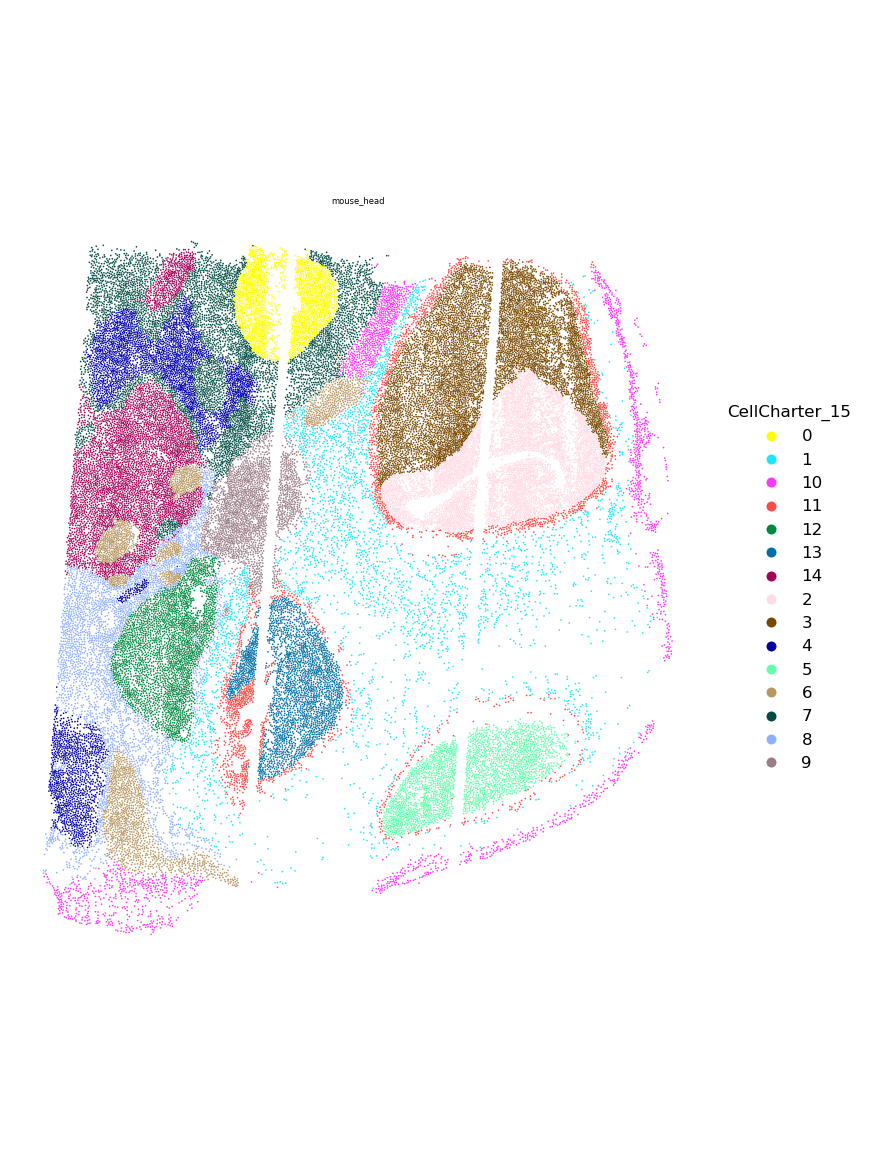

In [37]:
spatial_utils.plot_spatial_compact_fast(
    adata,
    color="CellCharter_15",
    groupby="sample_id",
    spot_size=1,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)
